In [1]:
from setup_notebook import setup_project_path
setup_project_path()

In [2]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR

In [3]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir = PROCESSED_DATA_DIR
model_dir = MODELS_DIR

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
def generate_predictions(features_file):
    df_KPI = pd.read_csv(features_file)
    df_KPI = df_KPI[df_KPI.backtesting_limit>=360]
    # print(df_KPI.shape)

    model = lightgbm.Booster(model_file = os.path.join(model_dir,'lgbm_cbr_model_2025-09-23.txt'))

    cols_with_prefix = ['frr', 'repayment_speed', 'avg_cum_days_disabled',
                    'at_risk_rate', 'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate']

    df_long = (pd.wide_to_long(
        df_KPI,
        stubnames=cols_with_prefix,
        i=["accounts_group", "reg_month", "country", "product_group", "area", "primary_product"],
        j="backtesting",
        sep="_",
        suffix=r"\d+"
    ).reset_index()
    .dropna(subset=cols_with_prefix)
    )

    df_long = df_long[df_long.backtesting>=360].sample(frac=1)

    X = df_long[["avg_planned_repayment_days", "backtesting", "frr", "repayment_speed", \
                "avg_cum_days_disabled", "at_risk_rate", "disabled_gt_two_week_rate", "unlocked_rate", "disabled_rate", \
                    "avg_upfront_price_usd", "avg_unlock_price_usd"]]
    print(X.shape)

    y_pred = model.predict(X)

    df_long_copy = df_long.copy()
    df_long_copy['predicted_frr'] = y_pred
    df_long_copy['predicted_revenue_USD'] = np.round(df_long_copy['predicted_frr']*df_long_copy['total_follow_on_revenue_usd'],2)
    return df_long_copy



In [6]:
df_long_copy_sep = generate_predictions(features_file='../data/KPIs_data_processed_2025-09-01.csv')
df_long_copy_sep["date_uploaded"] = '2025-09-01'

df_long_copy_aug = generate_predictions(features_file='../data/KPIs_data_processed_2025-08-01.csv')
df_long_copy_aug["date_uploaded"] = '2025-08-01'

(730194, 11)
(710374, 11)


In [7]:
df_long_copy_sep = df_long_copy_sep[df_long_copy_sep.backtesting==df_long_copy_sep.cohort_age_backtesting]
df_long_copy_aug = df_long_copy_aug[df_long_copy_aug.backtesting==df_long_copy_aug.cohort_age_backtesting]

In [8]:
df_long_copy_sep[df_long_copy_sep['accounts_group']=='2024-07_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,backtesting,age_in_months,avg_planned_repayment_days,avg_unlock_price_usd,...,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,predicted_frr,predicted_revenue_USD,date_uploaded
1602025,2024-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,2024-07,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,360,13,405,49.0,...,0.537252,0.6105,128.0,0.0,0.130435,0.014493,0.42029,0.882094,2833.35,2025-09-01


In [9]:
df_long_copy_aug[df_long_copy_aug['accounts_group']=='2024-07_Kenya_Lanterns_Kakamega_Sun King Pro EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,backtesting,age_in_months,avg_planned_repayment_days,avg_unlock_price_usd,...,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,predicted_frr,predicted_revenue_USD,date_uploaded
1599205,2024-07_Kenya_Lanterns_Kakamega_Sun King Pro E...,2024-07,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,360,12,405,49.0,...,0.537252,0.6105,128.0,0.0,0.130435,0.014493,0.42029,0.882094,2833.35,2025-08-01


In [10]:
# df_truth = pd.read_csv("../data/processed/truths_1080.csv")
# df_truth.head()
# df_long_copy_sep = pd.merge(left=df_long_copy_sep, right=df_truth, on="accounts_group")

In [11]:
df_long_copy = pd.concat([df_long_copy_sep, df_long_copy_aug])

# df_long_copy["date_uploaded"] = pd.to_datetime(df_long_copy["date_uploaded"], format="%Y-%m-%d")
# df_long_copy["reg_month"] = pd.to_datetime(df_long_copy["reg_month"], format="%Y-%m")

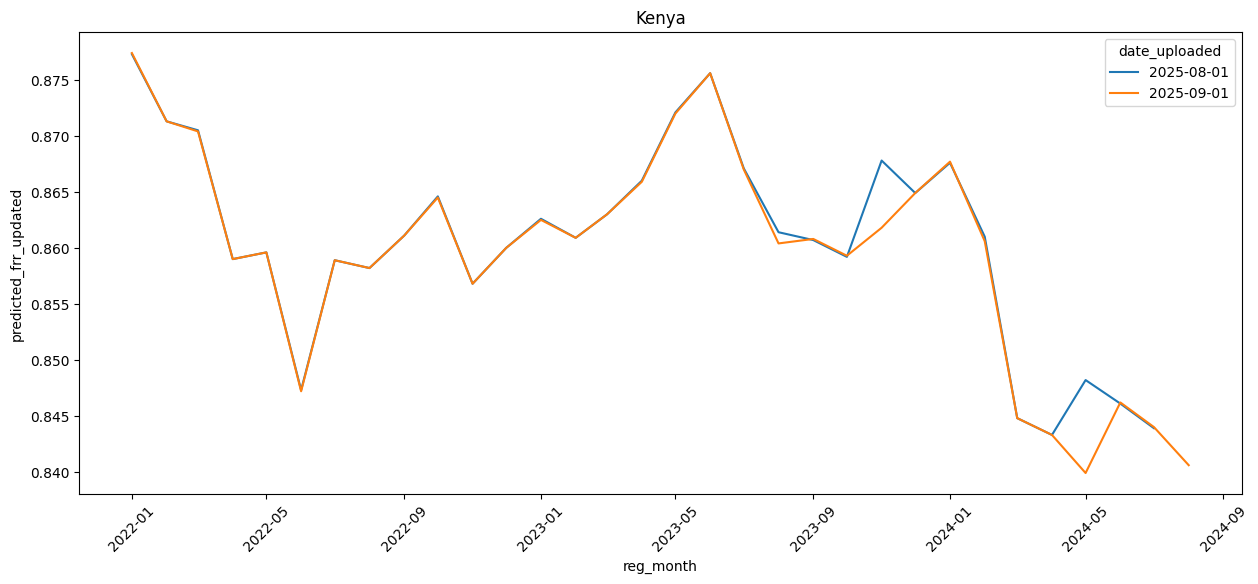

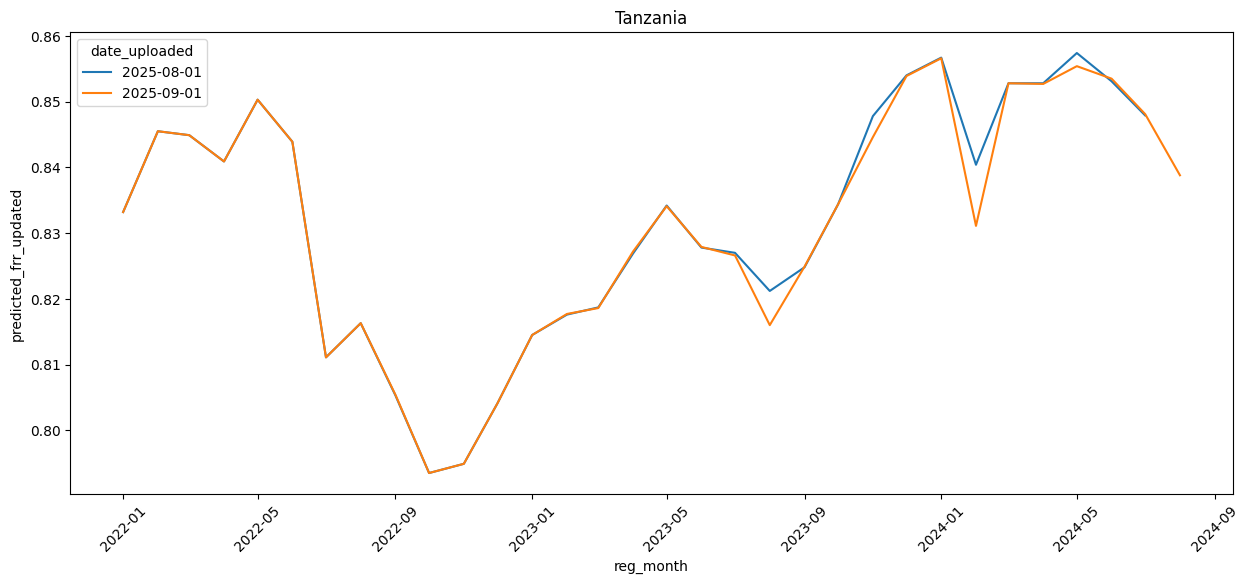

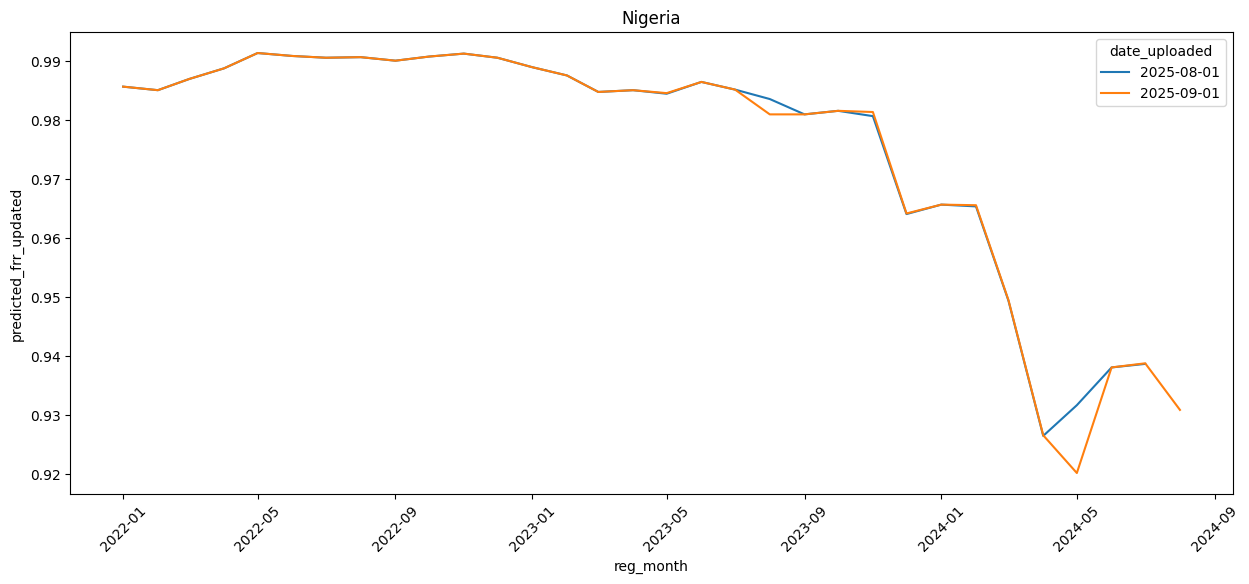

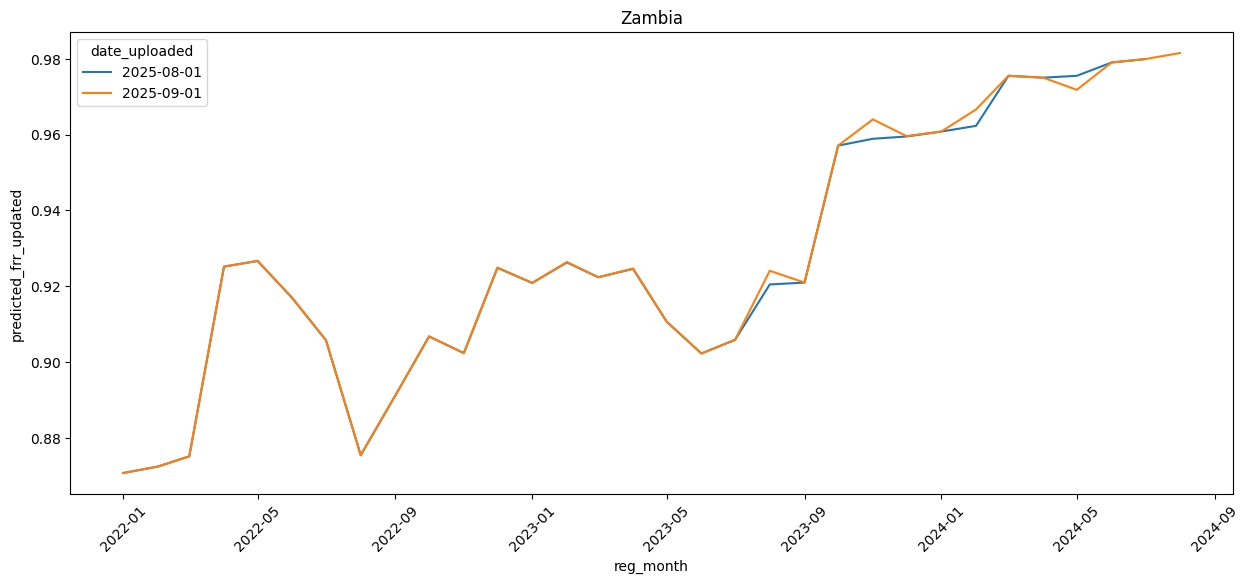

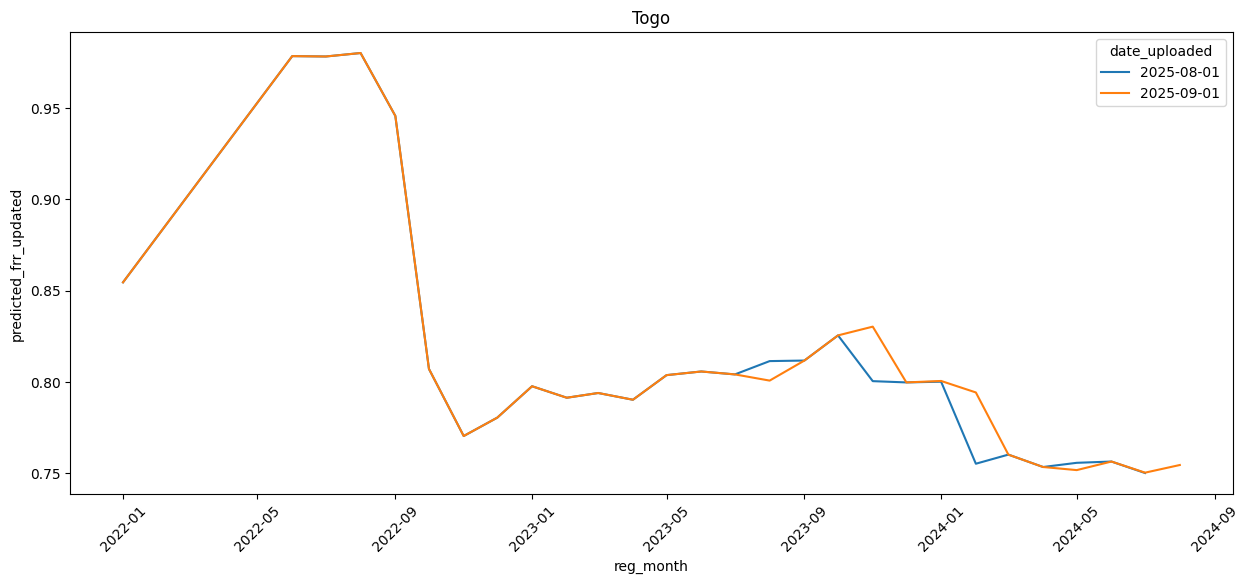

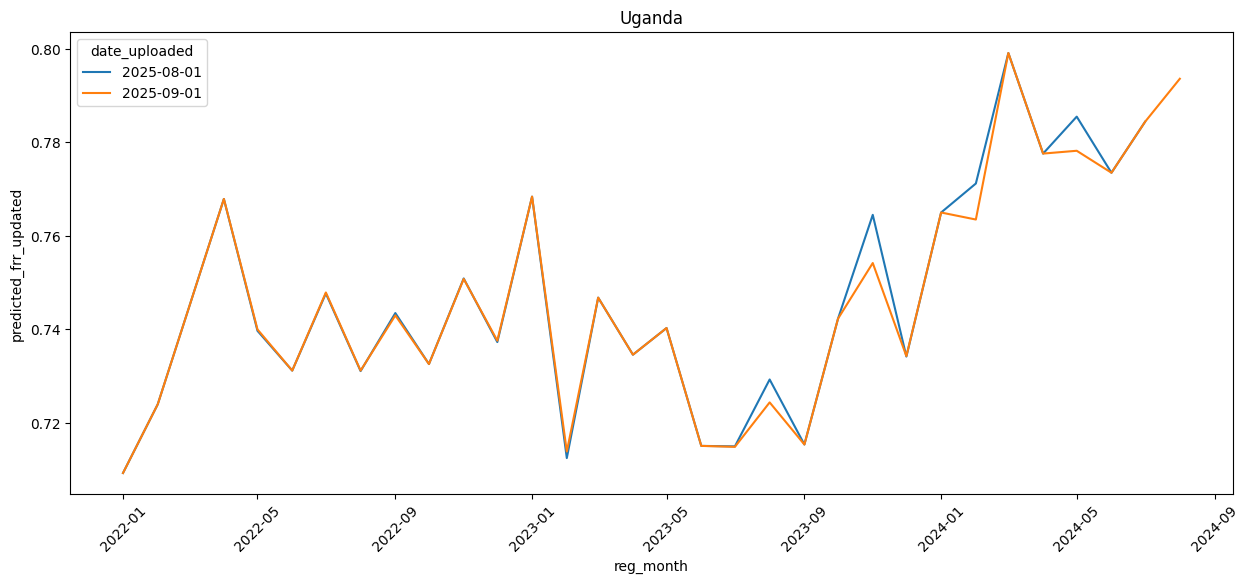

In [12]:
df_country = df_long_copy.groupby(["reg_month", "country", 'backtesting', "date_uploaded"]).agg(
    total_follow_on_price=('total_follow_on_revenue_usd', "sum"),
    total_predicted_fr=('predicted_revenue_USD', 'sum')
).reset_index()
df_country["predicted_frr_updated"] = np.round(df_country.total_predicted_fr/df_country.total_follow_on_price,4)
df_country["reg_month"] = pd.to_datetime(df_country["reg_month"], format="%Y-%m")
for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    subset = df_country[(df_country.country==country) & (df_country.reg_month>="2022-01-01")]
    ax = sns.lineplot(data=subset, x="reg_month", y="predicted_frr_updated", hue="date_uploaded")
    # for x, y in zip(subset["reg_month"], subset["predicted_frr_updated"]):
    #     ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [13]:
subset

,reg_month,country,backtesting,date_uploaded,total_follow_on_price,total_predicted_fr,predicted_frr_updated
788,2022-01-01,Uganda,720,2025-08-01,304291.297498,215846.82,0.7093
789,2022-01-01,Uganda,720,2025-09-01,304291.297498,215846.82,0.7093
804,2022-02-01,Uganda,720,2025-08-01,252264.881831,182649.98,0.7240
805,2022-02-01,Uganda,720,2025-09-01,252264.881831,182649.98,0.7240
820,2022-03-01,Uganda,720,2025-08-01,196493.720456,146348.73,0.7448
...,...,...,...,...,...,...,...
1384,2024-06-01,Uganda,360,2025-08-01,160415.330622,124088.58,0.7735
1385,2024-06-01,Uganda,360,2025-09-01,160415.330622,124088.58,0.7735
1408,2024-07-01,Uganda,360,2025-08-01,160573.210349,125960.48,0.7844
1409,2024-07-01,Uganda,360,2025-09-01,160558.098072,125947.15,0.7844


In [14]:
df_long_copy

,accounts_group,reg_month,country,product_group,area,primary_product,backtesting,age_in_months,avg_planned_repayment_days,avg_unlock_price_usd,...,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,predicted_frr,predicted_revenue_USD,date_uploaded
1308068,2023-10_Nigeria_Phones_Alakia_Infinix Hot 12 P...,2023-10,Nigeria,Phones,Alakia,Infinix Hot 12 Play (4+64),630,22,217,119.0,...,1.000000,1.0000,67.0,0.000000,0.000000,1.000000,0.000000,0.998872,1401.12,2025-09-01
729229,2022-06_Uganda_Lanterns_Sironko_Sun King Boom ...,2022-06,Uganda,Lanterns,Sironko,Sun King Boom EasyBuy,720,38,402,76.0,...,0.701575,0.7015,114.0,0.000000,0.416667,0.500000,0.416667,0.728217,651.91,2025-09-01
1108689,2023-05_India_SHS Entry-Level_Rajkhariar_Sun K...,2023-05,India,SHS Entry-Level,Rajkhariar,Sun King Home 40 Plus EasyBuy,720,27,187,60.0,...,1.000000,1.0000,70.0,0.000000,0.000000,1.000000,0.000000,0.999015,327.71,2025-09-01
1323298,2023-11_Kenya_Lanterns_Emali_Sun King Boom Eas...,2023-11,Kenya,Lanterns,Emali,Sun King Boom EasyBuy,630,21,402,56.0,...,0.853552,0.8535,164.0,0.013158,0.138053,0.592920,0.288496,0.919323,27738.97,2025-09-01
170659,2019-10_Tanzania_SHS Entry-Level_Usa River_Sun...,2019-10,Tanzania,SHS Entry-Level,Usa River,Sun King Home 60 EasyBuy,720,70,369,111.0,...,0.819105,0.8191,251.0,0.000000,0.000000,0.642857,0.214286,0.897856,1416.30,2025-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650619,2022-04_Kenya_SHS with TV_Nandi Hills_Sun King...,2022-04,Kenya,SHS with TV,Nandi Hills,Sun King Home 600 EasyBuy,720,39,633,492.0,...,0.652277,0.6522,305.0,0.000000,0.000000,0.000000,0.000000,0.868711,1516.72,2025-08-01
666809,2022-05_Kenya_Lanterns_Wajir_Sun King Boom Eas...,2022-05,Kenya,Lanterns,Wajir,Sun King Boom EasyBuy,720,38,368,52.0,...,0.975000,0.9750,342.0,0.000000,0.000000,0.500000,0.500000,1.003563,126.00,2025-08-01
662619,2022-04_Tanzania_SHS with TV Upgrade_Nyanza_Su...,2022-04,Tanzania,SHS with TV Upgrade,Nyanza,Sun King Home 400 Easybuy GSM,720,39,614,914.0,...,0.642957,0.6505,277.0,0.000000,0.111111,0.333333,0.444444,0.741323,6533.73,2025-08-01
1140949,2023-05_Uganda_Phones_Fort Portal_Samsung A03s,2023-05,Uganda,Phones,Fort Portal,Samsung A03s,720,26,367,388.0,...,0.173728,0.1737,166.0,0.000000,1.000000,0.000000,1.000000,0.236421,87.70,2025-08-01


In [15]:
df_country

,reg_month,country,backtesting,date_uploaded,total_follow_on_price,total_predicted_fr,predicted_frr_updated
0,2016-01-01,Kenya,720,2025-08-01,1.418446e+03,1367.27,0.9639
1,2016-01-01,Kenya,720,2025-09-01,1.418446e+03,1367.27,0.9639
2,2016-02-01,Kenya,720,2025-08-01,7.589929e+03,7233.88,0.9531
3,2016-02-01,Kenya,720,2025-09-01,7.589929e+03,7233.88,0.9531
4,2016-03-01,Kenya,720,2025-08-01,9.735017e+03,9231.57,0.9483
...,...,...,...,...,...,...,...
1418,2024-08-01,South Africa,360,2025-09-01,9.736267e+03,9420.85,0.9676
1419,2024-08-01,Tanzania,360,2025-09-01,3.047910e+06,2556726.45,0.8388
1420,2024-08-01,Togo,360,2025-09-01,1.473522e+06,1111496.66,0.7543
1421,2024-08-01,Uganda,360,2025-09-01,1.734507e+05,137644.71,0.7936


In [16]:
df_country["reg_month"] = pd.to_datetime(df_country["reg_month"])
df_country["date_uploaded"] = pd.to_datetime(df_country["date_uploaded"])

pivoted = df_country.pivot_table(
    index=["country", "reg_month",],
    columns="date_uploaded",
    values=["predicted_frr_updated"]
).reset_index()
pivoted.columns = [
    str(c[0]) if c[1] == "" or pd.isna(c[1]) else f"{c[0]}_{c[1].date()}"
    for c in pivoted.columns.to_flat_index()
]

pivoted["diff"] = pivoted["predicted_frr_updated_2025-09-01"] - pivoted["predicted_frr_updated_2025-08-01"]
pivoted.head()

,country,reg_month,predicted_frr_updated_2025-08-01,predicted_frr_updated_2025-09-01,diff
0,Cameroon,2022-11-01,1.0036,1.0036,0.0
1,Cameroon,2022-12-01,0.9983,0.9983,0.0
2,Cameroon,2023-01-01,0.9838,0.9838,0.0
3,Cameroon,2023-02-01,0.9733,0.9733,0.0
4,Cameroon,2023-03-01,0.9373,0.9373,0.0


In [17]:

backtestings = np.array([30, 60, 90, 180, 270, 360, 450, 540, 630, 720], dtype=int)
months = backtestings // 30

base_current = pd.to_datetime("2025-09-01")
base_prev = pd.to_datetime("2025-08-01")

backtesting_month_current = [base_current - pd.DateOffset(months=m+1) for m in months]
backtesting_month_prev = [base_prev - pd.DateOffset(months=m+2) for m in months]

data = {
    "Months": months,
    "backtesting_month_current": backtesting_month_current,
    "backtesting_month_prev": backtesting_month_prev,
    "backtesting_shift": backtestings,
}
backtestings_df = pd.DataFrame(data)

print(backtestings_df)


   Months backtesting_month_current backtesting_month_prev  backtesting_shift
0       1                2025-07-01             2025-05-01                 30
1       2                2025-06-01             2025-04-01                 60
2       3                2025-05-01             2025-03-01                 90
3       6                2025-02-01             2024-12-01                180
4       9                2024-11-01             2024-09-01                270
5      12                2024-08-01             2024-06-01                360
6      15                2024-05-01             2024-03-01                450
7      18                2024-02-01             2023-12-01                540
8      21                2023-11-01             2023-09-01                630
9      24                2023-08-01             2023-06-01                720


In [18]:
discrepancies = pd.merge(left=pivoted, right=backtestings_df, left_on="reg_month", right_on="backtesting_month_current", how="left")
discrepancies["backtesting_shift"] = discrepancies["backtesting_shift"].astype("Int64")
discrepancies = discrepancies[discrepancies.backtesting_shift.isin([450, 540, 630, 720])]

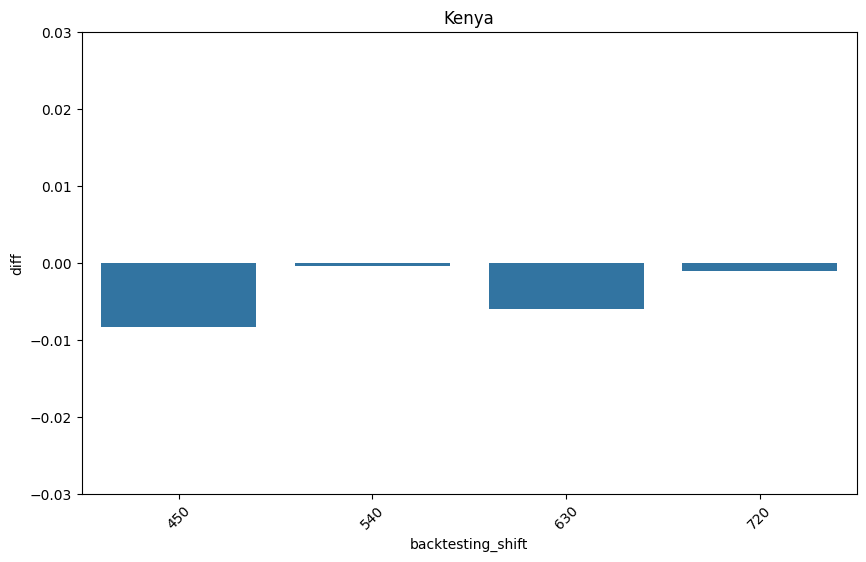

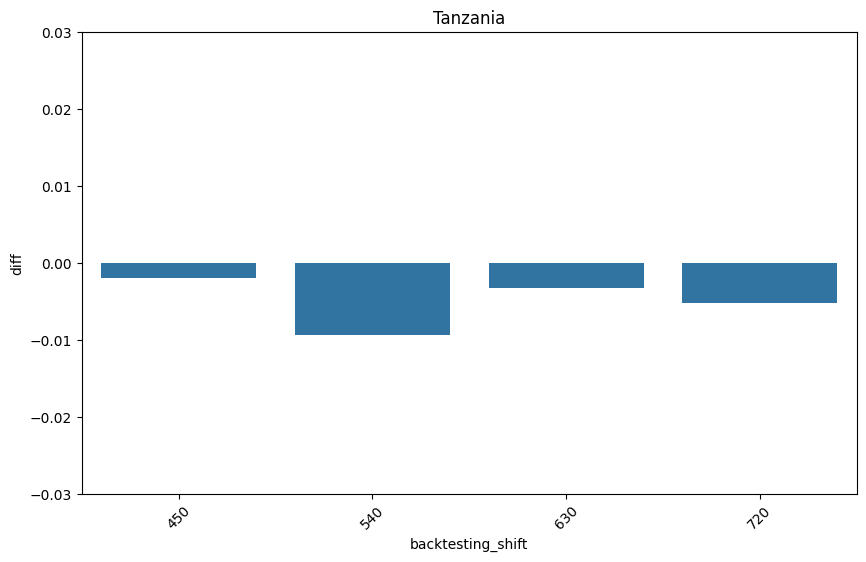

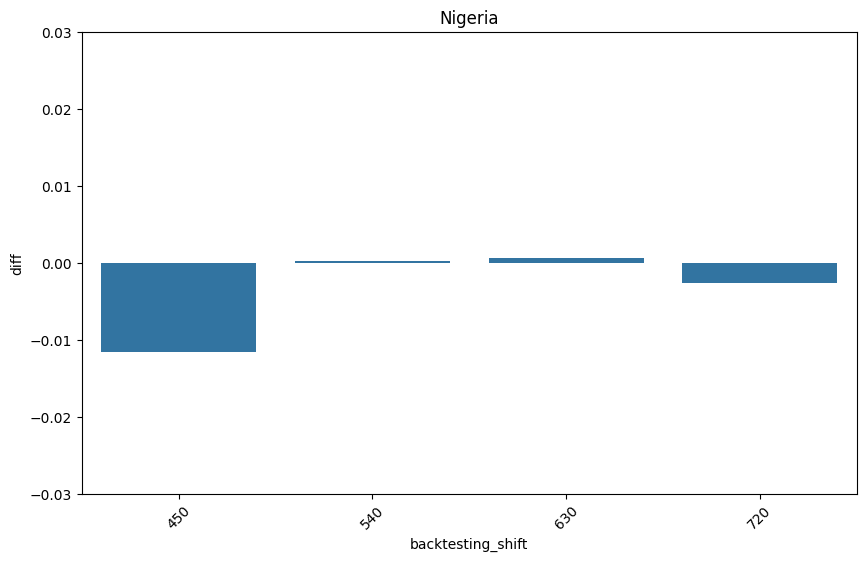

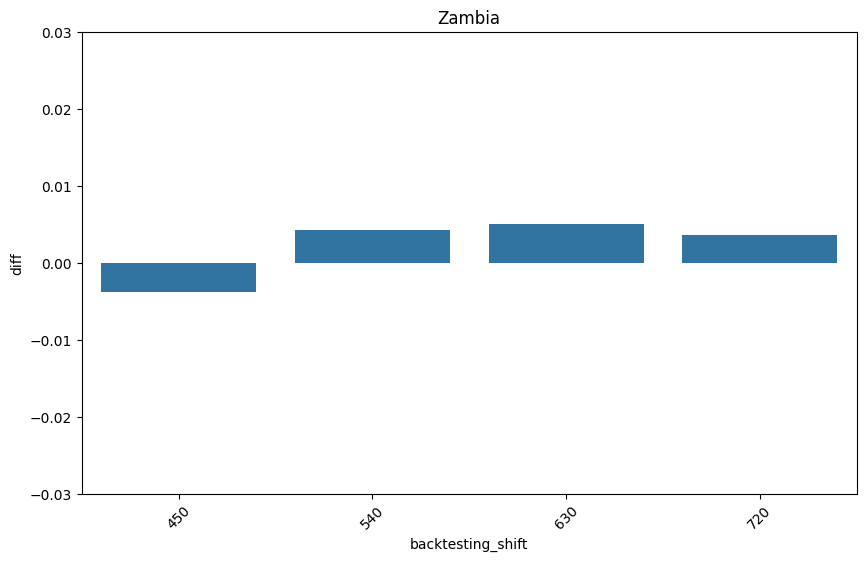

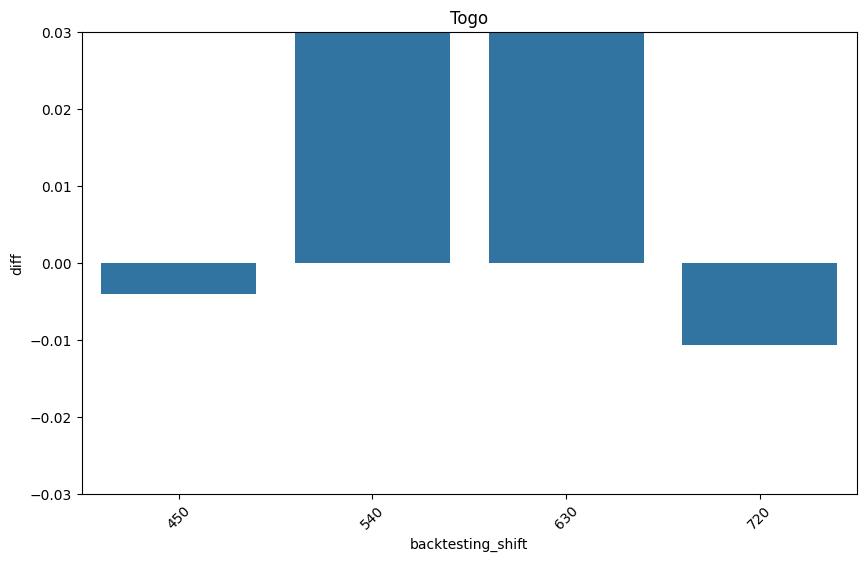

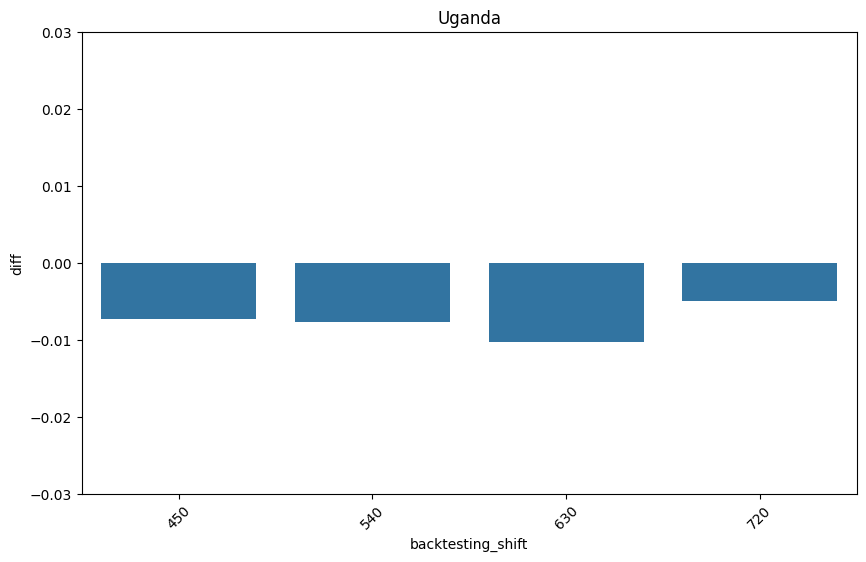

In [19]:
for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(10, 6))
    plt.ylim((-0.03, 0.03))
    sns.barplot(data=discrepancies[discrepancies.country==country], x="backtesting_shift", y="diff")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [24]:
discrepancies[discrepancies.country.isin(["Kenya", "Nigeria", "Tanzania", "Uganda", "Zambia", "Togo"])].groupby("country").agg(
    mean_diff = ("diff", "mean"),
    min_diff = ("diff", "min"),
    max_diff = ("diff", "max"),
    median_diff = ("diff", "median"),
).reset_index()

,country,mean_diff,min_diff,max_diff,median_diff
0,Kenya,-0.003925,-0.0083,-0.0004,-0.00350
1,Nigeria,-0.003300,-0.0115,0.0007,-0.00120
2,Tanzania,-0.004925,-0.0093,-0.0020,-0.00420
3,Togo,0.013575,-0.0107,0.0391,0.01295
4,Uganda,-0.007550,-0.0103,-0.0049,-0.00750
5,Zambia,0.002325,-0.0037,0.0051,0.00395
